
Goal:
- Understand the credit scoring dataset
- Analyze target distribution
- Identify data quality issues
- Derive insights for feature engineering and modeling


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 100)

PROJECT_ROOT = Path.cwd().parent
RAW_PATH = PROJECT_ROOT / 'data/raw/application_train.csv'

In [2]:
df = pd.read_csv(RAW_PATH)
df.shape

(307511, 122)

The dataset contains 307511 rows and 122 columns.
Each row represents a loan application.

In [3]:
df['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Data is highly imbalanced, so we should use Recall as the main metric, because classifying defaulters as non-defaulters will lead to losses for a business.

In [4]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [5]:
def bin_target_summary(df, feature, target='TARGET', q=10):
    tmp = df[[feature, target]].dropna().copy()
    tmp['bin'] = pd.qcut(tmp[feature], q=q, duplicates='drop')

    return(
        tmp.groupby('bin', observed=True)[target]
        .agg(count='count', default_rate='mean')
    )
    

In [6]:
age_years = -df['DAYS_BIRTH'] / 365.25
age_summary = bin_target_summary(
    df.assign(age_years=age_years), 
    'age_years'
    )
age_summary

,count,default_rate
bin,,
"(20.503, 28.156]",30752,0.115700
"(28.156, 32.016]",30760,0.109948
"(32.016, 35.975]",30745,0.098065
"(35.975, 39.469]",30759,0.088527
"(39.469, 43.121]",30745,0.079037
"(43.121, 47.146]",30764,0.077948
"(47.146, 51.704]",30733,0.071357
"(51.704, 56.055]",30758,0.063431
"(56.055, 60.728]",30757,0.054232


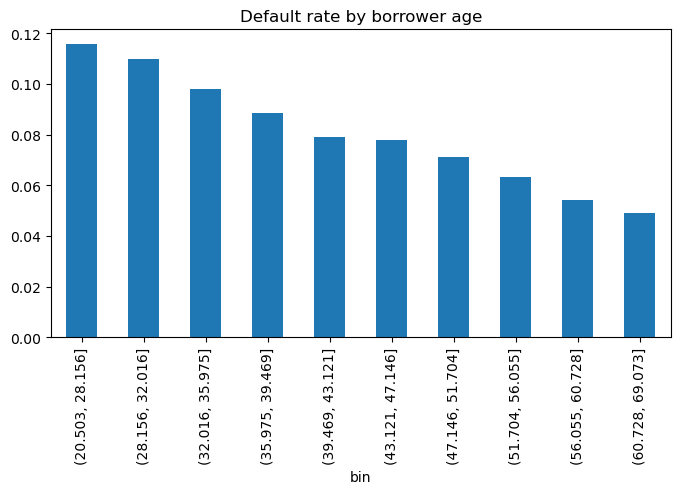

In [7]:
age_summary['default_rate'].plot(kind='bar', figsize=(8, 4), title='Default rate by borrower age');

Monotonic relation: Younger borrower -> higher risk. 

Strong feature.

In [8]:
income_thousands = df['AMT_INCOME_TOTAL'] // 1000
income_summary = bin_target_summary(
    df.assign(income_thousands=income_thousands), 
    'income_thousands', 
    q=9
    )
income_summary

,count,default_rate
bin,,
"(24.999, 85.0]",35207,0.081830
"(85.0, 108.0]",34192,0.082739
"(108.0, 117.0]",33807,0.087792
"(117.0, 135.0]",46232,0.084638
"(135.0, 157.0]",33625,0.087494
"(157.0, 180.0]",32531,0.083674
"(180.0, 216.0]",23616,0.080200
"(216.0, 270.0]",41142,0.073137
"(270.0, 117000.0]",27159,0.061379


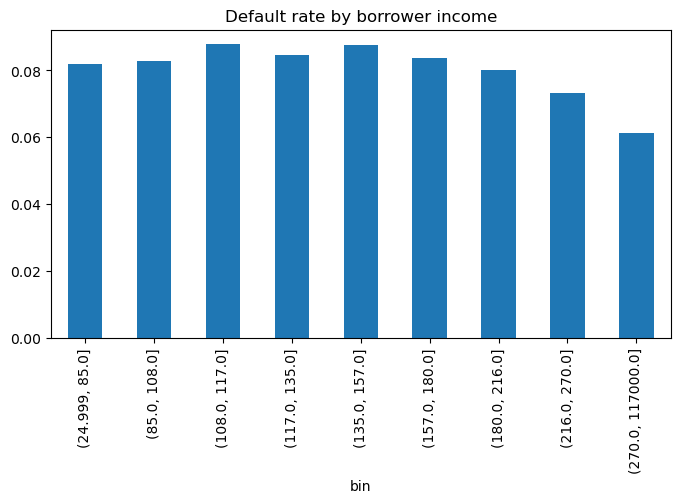

In [9]:
income_summary['default_rate'].plot(kind='bar', figsize=(8, 4), title='Default rate by borrower income');

Risk starts decreasing monotonic from ~180k income

In [10]:
credit_thousands = df['AMT_CREDIT'] // 1000
credit_summary = bin_target_summary(
    df.assign(credit_thousands=credit_thousands),
      'credit_thousands'
    )
credit_summary

,count,default_rate
bin,,
"(44.999, 180.0]",33206,0.067217
"(180.0, 254.0]",31782,0.077843
"(254.0, 306.0]",27328,0.082004
"(306.0, 432.0]",31027,0.100396
"(432.0, 513.0]",30507,0.095781
"(513.0, 604.0]",30805,0.105210
"(604.0, 755.0]",34055,0.085303
"(755.0, 900.0]",29954,0.070842
"(900.0, 1133.0]",28254,0.068769


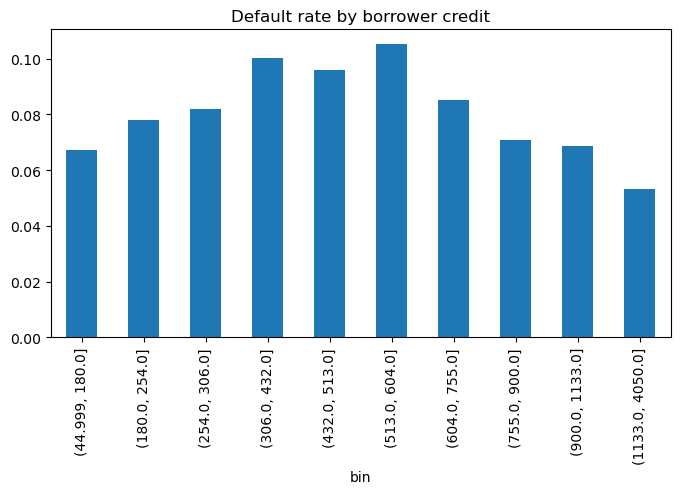

In [11]:
credit_summary['default_rate'].plot(kind='bar', figsize=(8, 4), title='Default rate by borrower credit');

In [12]:
annuity_summary = bin_target_summary(df, 'AMT_ANNUITY')
annuity_summary

,count,default_rate
bin,,
"(1615.499, 11074.5]",30880,0.071049
"(11074.5, 14701.5]",30627,0.067914
"(14701.5, 18189.0]",30763,0.084777
"(18189.0, 21865.5]",30731,0.086883
"(21865.5, 24903.0]",30772,0.084752
"(24903.0, 28062.0]",30790,0.091069
"(28062.0, 32004.0]",30690,0.100815
"(32004.0, 37516.5]",30762,0.085983
"(37516.5, 45954.0]",30808,0.076214


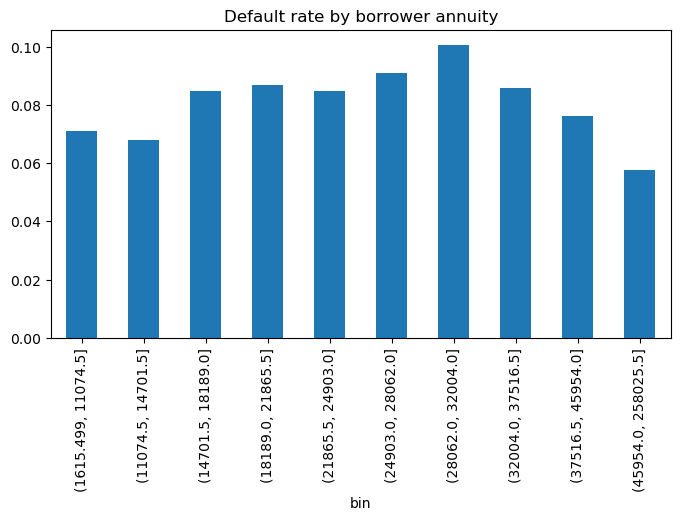

In [13]:
annuity_summary['default_rate'].plot(kind='bar', figsize=(8, 4), title='Default rate by borrower annuity');

Observations:

- Risk is low when annuity / credit are small
- The biggest risk in the middle annuity-credit because of high cash-flow stress
- Risk is lower for high annuity / credit is because of stricter borrower selection
- Credit-Annuity will work better as ratios (will be engineered in the future pipeline)
- Annuity is a redundant feature due it repeats the credit pattern


In [14]:
population_summary = bin_target_summary(df, 'REGION_POPULATION_RELATIVE')
population_summary

,count,default_rate
bin,,
"(-0.00071, 0.00663]",30958,0.085729
"(0.00663, 0.00887]",32197,0.093021
"(0.00887, 0.0106]",32088,0.077194
"(0.0106, 0.0166]",28881,0.081472
"(0.0166, 0.0188]",33033,0.094451
"(0.0188, 0.0207]",30110,0.096579
"(0.0207, 0.0252]",29104,0.080333
"(0.0252, 0.0308]",34921,0.074711
"(0.0308, 0.0358]",34365,0.069082


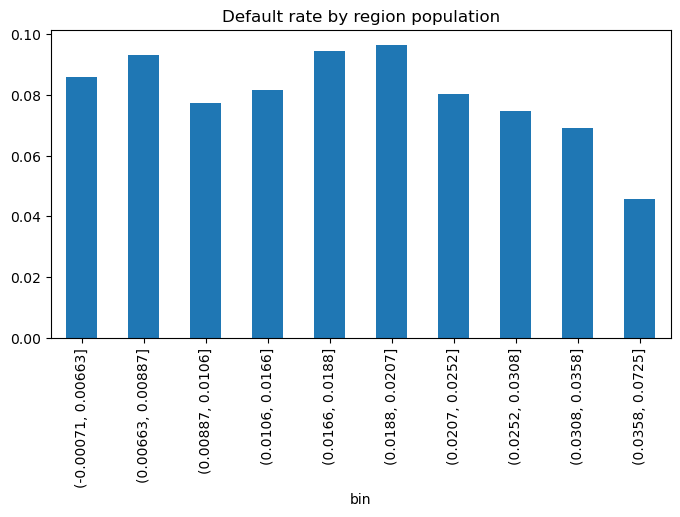

In [15]:
population_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by region population');

Risk is lower in regions with higher populations because of: 
- Urbanization
- Higher access to jobs
- Formal employment prevalence

Moderate signal.

In [16]:
df['DAYS_EMPLOYED'].isna().sum()

np.int64(0)

In [17]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan) #365243 means NO-EMPLOYED in dataset
employed_years = -df['DAYS_EMPLOYED'] / 365.25
employed_summary = bin_target_summary(
    df.assign(employed_years=employed_years),
      'employed_years'
      )
employed_summary

,count,default_rate
bin,,
"(-0.001, 0.912]",25235,0.110323
"(0.912, 1.689]",25276,0.114536
"(1.689, 2.516]",25159,0.110775
"(2.516, 3.422]",25250,0.102614
"(3.422, 4.512]",25204,0.096453
"(4.512, 5.914]",25186,0.085325
"(5.914, 7.644]",25206,0.074506
"(7.644, 10.064]",25193,0.067638
"(10.064, 14.601]",25217,0.058135


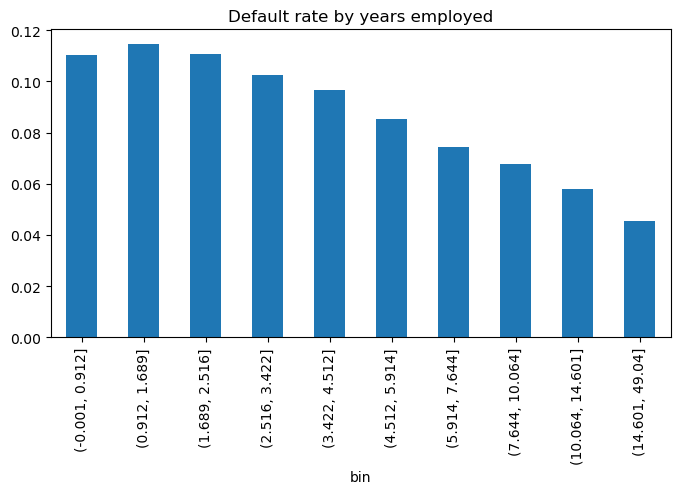

In [18]:
employed_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by years employed');

In [19]:
days_m = df['DAYS_EMPLOYED'].isna().mean()
print(f'NaN mean: {days_m}')
df.groupby(df['DAYS_EMPLOYED'].isna(), observed=True)['TARGET'].mean()

NaN mean: 0.18007160719453938


DAYS_EMPLOYED
False    0.086600
True     0.053996
Name: TARGET, dtype: float64

Observations:

- Monotonic relation: longer employed - lower risk. Strong feature
- Missing values relate to lower default risk, mainly because these values correspond to self-employed / entrepreneur borrowers, who have higher income and are evaluated differently by banks


In [20]:
year_reg_duration = -df['DAYS_REGISTRATION'] / 365.25
reg_summary = bin_target_summary(
    df.assign(year_reg_duration=year_reg_duration),
      'year_reg_duration'
      )
reg_summary

,count,default_rate
bin,,
"(-0.001, 1.889]",30762,0.096970
"(1.889, 4.082]",30742,0.090430
"(4.082, 6.954]",30769,0.085053
"(6.954, 9.684]",30749,0.087027
"(9.684, 12.331]",30759,0.086999
"(12.331, 14.946]",30731,0.086785
"(14.946, 18.552]",30758,0.079134
"(18.552, 22.533]",30747,0.072560
"(22.533, 27.192]",30762,0.066186


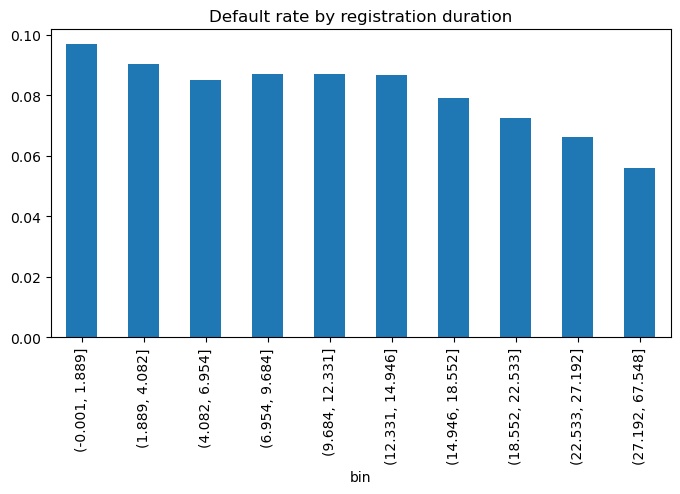

In [21]:
reg_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by registration duration');

In [22]:
id_reg_duration = -df['DAYS_ID_PUBLISH'] / 365.25
id_reg_summary = bin_target_summary(
    df.assign(id_reg_duration=id_reg_duration),
      'id_reg_duration'
      )
id_reg_summary

,count,default_rate
bin,,
"(-0.001, 1.999]",30785,0.101803
"(1.999, 3.773]",30763,0.097975
"(3.773, 5.596]",30751,0.093298
"(5.596, 7.266]",30707,0.089589
"(7.266, 8.909]",30764,0.083539
"(8.909, 10.626]",30776,0.077788
"(10.626, 11.422]",30761,0.076916
"(11.422, 12.129]",30702,0.065175
"(12.129, 12.934]",30831,0.061691


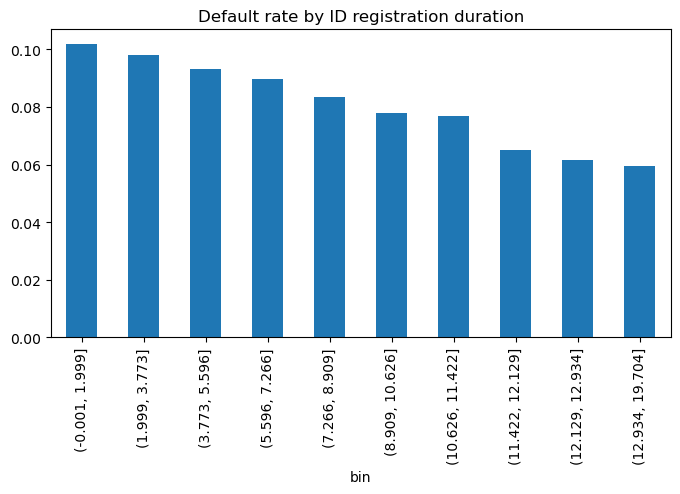

In [23]:
id_reg_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by ID registration duration');

Monotonic relation (registration_days and id_publish): Longer registration history -> Lower risk.

Earlier registration relates to unstable life situations / migration.

Strong feature.

In [24]:
car_age_summary = bin_target_summary(df, 'OWN_CAR_AGE')
car_age_summary

,count,default_rate
bin,,
"(-0.001, 2.0]",13266,0.062867
"(2.0, 4.0]",11927,0.051815
"(4.0, 6.0]",9977,0.054325
"(6.0, 7.0]",7424,0.058324
"(7.0, 9.0]",10907,0.066471
"(9.0, 12.0]",13224,0.077737
"(12.0, 14.0]",9160,0.086900
"(14.0, 17.0]",9834,0.086231
"(17.0, 22.0]",8521,0.094238


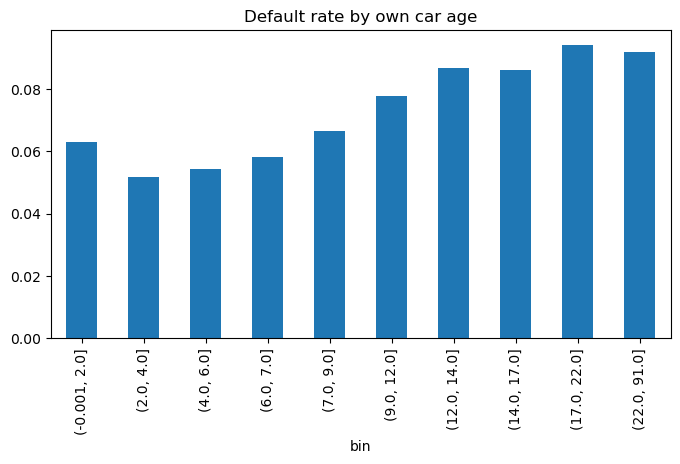

In [25]:
car_age_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by own car age');

Monotonic relation: Clients who have owned a car longer -> have a lower default risk due to a more stable life situation.

In [26]:
fam_size_summary = (
    df.assign(
        fam_size_group=pd.cut(
            df['CNT_FAM_MEMBERS'],
            [0,1,2,3,5,10,100],
            right=True
        )
    )
    .groupby('fam_size_group', observed=True)['TARGET']
    .agg(count='count', default_rate='mean')
)

fam_size_summary

,count,default_rate
fam_size_group,,
"(0, 1]",67847,0.083644
"(1, 2]",158357,0.075835
"(2, 3]",52601,0.087603
"(3, 5]",28175,0.087418
"(5, 10]",518,0.131274
"(10, 100]",11,0.181818


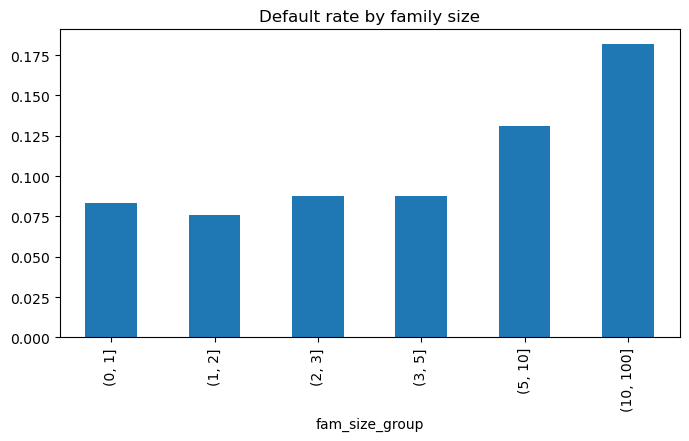

In [27]:
fam_size_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by family size');

Borrowers with >= 3 family members have higher risk due to higher financial burden.

In [28]:
children_summary = (
    df.assign(
        children_cnt_group=pd.cut(
            df['CNT_CHILDREN'],
            [0,1,2,3,5,10,100],
            right=True
        )
    )
    .groupby('children_cnt_group', observed=True)['TARGET']
    .agg(count='count', default_rate='mean')
)

children_summary

,count,default_rate
children_cnt_group,,
"(0, 1]",61119,0.089236
"(1, 2]",26749,0.087218
"(2, 3]",3717,0.096314
"(3, 5]",513,0.120858
"(5, 10]",34,0.235294
"(10, 100]",8,0.125000


Default risk increases with the number of children, but estimations for >= 3 children are unstable due to very small sample sizes. 

Signal Low-Moderate, should be treated cautiously.

In [29]:
region_summary = (
    df.groupby('REGION_RATING_CLIENT_W_CITY', observed=True)['TARGET']
    .agg(count='count', default_rate='mean')
    )

region_summary

,count,default_rate
REGION_RATING_CLIENT_W_CITY,,
1,34167,0.048409
2,229484,0.079178
3,43860,0.114022


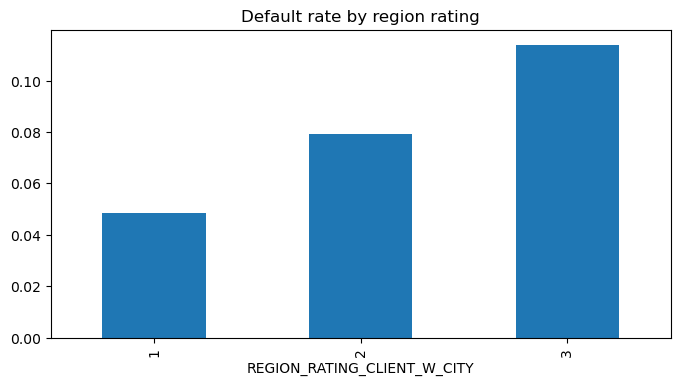

In [30]:
region_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by region rating');

Observations:

- REGION_RATING_CLIENT is a redundant feature as REGION_RATING_CLIENT_W_CITY gives a more precise result
- Monotonic relation: higher rating (1 - best) -> lower risk

In [31]:
def time_bins(h):
    if 6 <= h < 12:
        return 'morning'
    elif 12 <= h < 18:
        return 'afternoon'
    elif 18 <= h <= 23:
        return 'evening'
    else:
        return 'night'

In [32]:
process_start_summary = (
    df.assign(
        process_start_group=df['HOUR_APPR_PROCESS_START'].apply(time_bins)
    )
    .groupby('process_start_group', observed=True)['TARGET']
    .agg(count='count', default_rate='mean')
)

process_start_summary.sort_values(by='default_rate', ascending=False)

,count,default_rate
process_start_group,,
night,7389,0.095818
morning,132435,0.084676
afternoon,152998,0.077615
evening,14689,0.069984


Off-hours applications correlate with:
 - Urgent financial need
 - weak profile of borrower

Default risk is highest at night, but the volume of applications is small.

Weak signal -> excluded from baseline, may be tested later

In [33]:
ext1_summary = bin_target_summary(df, 'EXT_SOURCE_1')
ext1_summary

,count,default_rate
bin,,
"(0.013600000000000001, 0.213]",13414,0.175637
"(0.213, 0.296]",13413,0.115932
"(0.296, 0.369]",13414,0.090950
"(0.369, 0.438]",13412,0.083806
"(0.438, 0.506]",13415,0.066940
"(0.506, 0.573]",13412,0.060245
"(0.573, 0.64]",13413,0.051368
"(0.64, 0.71]",13413,0.043838
"(0.71, 0.787]",13413,0.035115


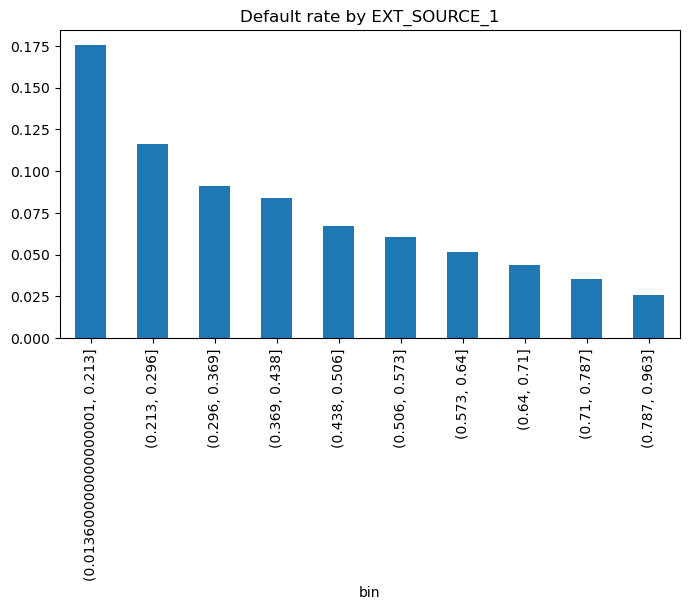

In [34]:
ext1_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by EXT_SOURCE_1');

In [35]:
ext2_summary = bin_target_summary(df, 'EXT_SOURCE_2')
ext2_summary

,count,default_rate
bin,,
"(-0.0009999183, 0.216]",30686,0.183504
"(0.216, 0.34]",30685,0.120776
"(0.34, 0.44]",30687,0.099586
"(0.44, 0.512]",30684,0.083627
"(0.512, 0.566]",30684,0.074241
"(0.566, 0.608]",30687,0.066543
"(0.608, 0.646]",30683,0.058469
"(0.646, 0.682]",30694,0.048837
"(0.682, 0.722]",30676,0.042020


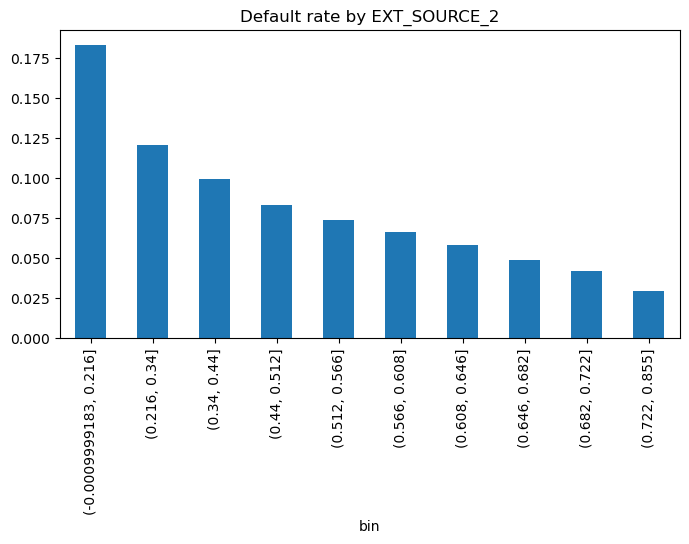

In [36]:
ext2_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by EXT_SOURCE_2');

In [37]:
ext3_summary = bin_target_summary(df, 'EXT_SOURCE_3')
ext3_summary

,count,default_rate
bin,,
"(-0.000473, 0.228]",24701,0.200032
"(0.228, 0.33]",24744,0.127546
"(0.33, 0.408]",25057,0.095103
"(0.408, 0.476]",24689,0.079793
"(0.476, 0.535]",24186,0.061771
"(0.535, 0.592]",25392,0.053442
"(0.592, 0.643]",24725,0.047442
"(0.643, 0.694]",24745,0.042150
"(0.694, 0.749]",23675,0.035312


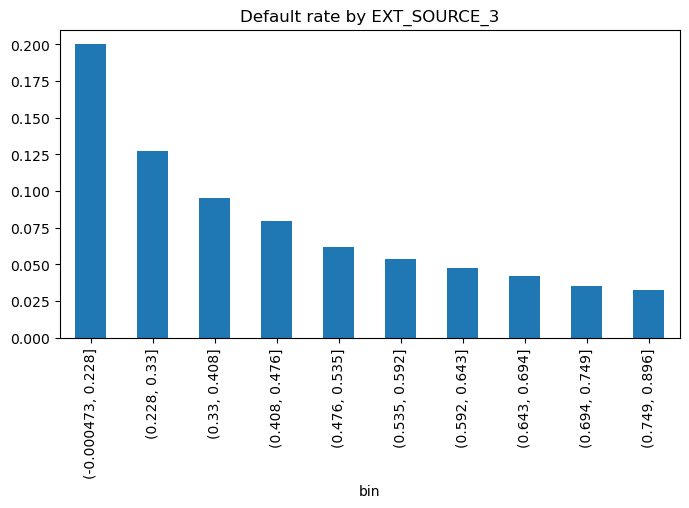

In [38]:
ext3_summary['default_rate'].plot(kind='bar', figsize=(8,4), title='Default rate by EXT_SOURCE_3');

Monotonic features: higher value -> lower default rate

EXT_SOURCE_(1,2,3) are the highest signals in the dataset.

In [39]:
m1 = df['EXT_SOURCE_1'].isna().mean()
print(f'mean: {m1}')
df.groupby(df['EXT_SOURCE_1'].isna())['TARGET'].mean()

mean: 0.5638107254699832


EXT_SOURCE_1
False    0.074955
True     0.085195
Name: TARGET, dtype: float64

In [40]:
m2 = df['EXT_SOURCE_2'].isna().mean()
print(f'mean: {m2}')
df.groupby(df['EXT_SOURCE_2'].isna())['TARGET'].mean()

mean: 0.0021462646864665006


EXT_SOURCE_2
False    0.080733
True     0.078788
Name: TARGET, dtype: float64

In [41]:
m3 = df['EXT_SOURCE_3'].isna().mean()
print(f'mean: {m3}')
df.groupby(df['EXT_SOURCE_3'].isna())['TARGET'].mean()

mean: 0.19825307062186392


EXT_SOURCE_3
False    0.077665
True     0.093119
Name: TARGET, dtype: float64

EXT_SOURCE_1 and EXT_SOURCE_3 exhibit substantial missing rates. For both features, missing values are associated with higher default risk, indicating that missingness carries predictive information and should be explicitly encoded. 

EXT_SOURCE_2 has negligible missingness and does not require a missing indicator.

In [42]:
binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
summaries = {}

for feature in binary_features:
    summaries[feature] = (df.groupby(feature, observed=True)['TARGET']
               .agg(count='count', default_rate='mean')
               .sort_values('default_rate', ascending=False))

summaries['CODE_GENDER']

,count,default_rate
CODE_GENDER,,
M,105059,0.101419
F,202448,0.069993
XNA,4,0.000000


In [43]:
summaries['FLAG_OWN_CAR']

,count,default_rate
FLAG_OWN_CAR,,
N,202924,0.085002
Y,104587,0.072437


In [44]:
summaries['FLAG_OWN_REALTY']

,count,default_rate
FLAG_OWN_REALTY,,
N,94199,0.083249
Y,213312,0.079616


Observations:
- Risk is higher for Males than Females
- Risk is higher for borrowers without a car/realty (less stable financial situation)
- FLAG_OWN_REALTY - weak feature only a 0.3% gap, don't include in baseline